# Evaluation of the System Behavior

In [1]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
sns.set_context('poster')
#sns.set_style('whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## Prepare Data

In [102]:
tasks = data.load('robomission-2018-03-10/tasks.csv')
levels = data.load('robomission-2018-03-10/levels.csv')
tasks = tasks.assign(level=tasks.level.apply(
    lambda name: levels[levels.name==name].level.values[0]))

ts = data.load('robomission-2018-03-10/task_sessions.csv')
ts = ts[ts.time_spent > 0]
ts = ts.assign(date=ts.end.str[:10])
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
# Count the order of the task session per student:
ts = ts.assign(order=ts.groupby('student').cumcount() + 1)
# Add cumulative time for each student:
ts = ts.assign(total_time=ts.groupby('student').time_spent.cumsum())
# Add level info
ts = ts.join(tasks.level, on='task')
ts.head()

,student,task,solved,start,end,time_spent,date,order,total_time,level
id,,,,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13,1,62,1
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12,1,63,4
13,29,8,True,2017-11-10T12:24:07.602156Z,2017-11-10T12:24:24.986604Z,17,2017-11-10,1,17,2
1,5,25,True,2017-11-10T10:25:08.451949Z,2017-11-10T10:25:22.612931Z,14,2017-11-10,1,14,1
2,29,25,True,2017-11-10T12:19:38.296521Z,2017-11-10T12:19:50.945672Z,12,2017-11-10,2,29,1


## Are students able to solve all tasks in the system in a reasonable time?

TODO: abstraction over the threshold

In [105]:
sum(ts.solved) / len(ts)

0.8630026086174327

In [106]:
reasonable_time = 15 * 60
sum((ts.time_spent <= reasonable_time) & ts.solved) / len(ts)

0.8379958621930377

Result: 86 % are solved, 84 % are solved in 15 minutes.

## Are students able to solve their first 5 tasks quickly (each in 2 minutes)?

TODO: abstraction over both thresholds

In [107]:
# Filter the first 5 task sessions
fts = ts[ts.order <= 5]

In [108]:
sum(fts.solved) / len(fts)

0.8660103910308996

In [109]:
sum((fts.time_spent <= reasonable_time) & fts.solved) / len(fts)

0.8460486737763194

In [110]:
quick_time = 2 * 60
sum((fts.time_spent <= quick_time) & fts.solved) / len(fts)

0.6579163248564397

Result: Within the first 5 tasks for each student, 87 % are solved, 85 % in 15 minutes, but only 66 % in 2 minutes.

## Do students progress to the second level in at most 10 minutes?

ISSUE:
- We have not collected info about recommendations, so we can't sepparate recommended and self-selected task. (-> Added to next implementation steps.)

In [223]:
ts = ts.assign(total_mins=(5 * (ts.total_time//(5*60))).clip_upper(60))
ts = ts.assign(max_level=ts.groupby('student')['level'].cummax())
n_students = ts.student.nunique()

In [215]:
def prop_students_at_level_after_time(level_threshold, time_threshold):
    remaining = set(
        ts[ts.total_time >= time_threshold].student.values)
    good = remaining & set(
        ts[(ts.total_time <= time_threshold)
        & (ts.max_level >= level_threshold)].student.values)
    return len(good) / len(remaining)

prop_students_at_level_after_time(
    level_threshold=2,
    time_threshold=10 * 60)

0.7324723247232472

Result: 73% of students who are still learning after 10 minutes has reached 2nd level at that time. (Artefact: the time limit includes the solving time of first task in the second level. Note: we don't require the students to solve the task.)

**Abstracting over time.**

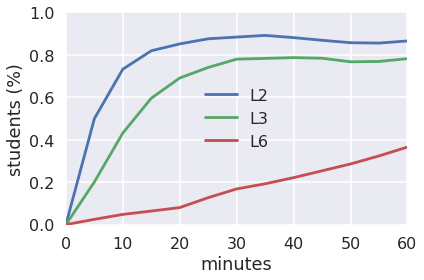

In [235]:
times = pd.Series(np.linspace(0, 60, num=13))
students_at_levels = pd.DataFrame({
    level: times.apply(
        lambda m: prop_students_at_level_after_time(
        level_threshold=level, time_threshold=m*60))
    for level in [2, 3, 6]}).set_index(times)
students_at_levels.columns = ['L2', 'L3', 'L6']
ax = students_at_levels.plot()
ax.set_xlim(0, 60)
ax.set_ylim(0, 1)
ax.set_xlabel('minutes')
ax.set_ylabel('students (%)')
plt.tight_layout()
plt.savefig('../img/students-at-levels.pdf')

**Abstracting over time and level.**

Proportion of task sessions (not students) in each level with the increasing total time:

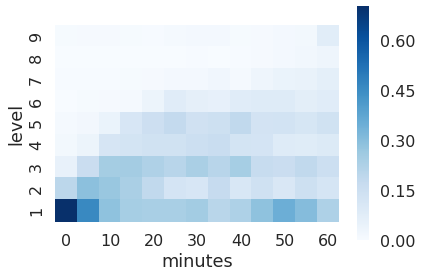

In [224]:
counts = ts.groupby(['level', 'total_mins']).student.count().unstack()
counts = counts.fillna(0)
perc = counts.sort_index(ascending=False) / counts.sum()
ax = sns.heatmap(perc, vmin=0, vmax=0.7, xticklabels=2, square=True,
                 cmap='Blues')
ax.set_xlabel('minutes')
plt.tight_layout()
plt.savefig('../img/task-sessions-at-levels.pdf')